In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('..')
import attrs, utils

from datetime import datetime

DATA_PATH = attrs.DATA_PATH

Set path for data

In [2]:
block_bootstrap_samples = np.load(os.path.join(DATA_PATH, 'bootstrapped_pensacola_JJASON.npy'))

Quantiles to compute

In [3]:
qs = np.arange(0.05, 1, 0.05)
N = np.shape(block_bootstrap_samples)[0]    # Number of bootstrap samples

Create bootstrap matrix: `B[i,j]` is the bootstrapped slope of the *i*th sample, *j*th quantile (units mm/day).

Runtime is about 10 mins on my laptop. Saved B for later

In [15]:

B = np.empty((N, len(qs)))    # Initialize matrix

xs = np.arange(np.shape(block_bootstrap_samples)[1])    # Time vector

# Populate quantile regression matrix
for i in range(N):
    for j, q in enumerate(qs):
        ys = block_bootstrap_samples[i, :]
        B[i, j] = utils.q_regression(xs, ys, q)[1]

np.save(os.path.join(DATA_PATH, 'pensacola_bootstrap_slopes.npy'), B)

Load bootstrap slopes

In [4]:
B = np.load(os.path.join(DATA_PATH, 'pensacola_bootstrap_slopes.npy'))

Compute coefficient matrix using legendre basis functions
* `C[i, j]` is the coefficient of the *j*th basis function ($c_j$) for the *i*th bootstrapped sample.

In [8]:
# From bootstrapped matrix, compute coefficient matrix using legendre basis functions
C = np.zeros((N, 4))
A = utils.compute_basis_matrix('legendre')

for i in range(N):
    C[i, :] = linalg.lstsq(A, B[i, :])[0]

# First few samples
C[0:3,:]

array([[ 1.78442672e-03,  4.19159726e-03,  2.93769844e-03,
        -7.22319109e-04],
       [-1.03795765e-03,  2.23322501e-03,  4.44327255e-03,
         4.52826431e-05],
       [ 4.46943774e-03,  3.96675784e-03,  2.14948399e-03,
        -4.83585579e-06]])

Create 95% significance intervals:
* `significance_intervals[i]` is the significance interval for the ith moment coefficient.

In [9]:
significance_intervals = [
    pd.Interval(np.quantile(C[:, j], 0.025), np.quantile(C[:, j], 0.975),)
    for j in range(4)
]

Compute coefficients for the true timeseries (not block bootstrapped). Plots of projection onto legendre basis

[8.76780449e-03 1.15569198e-03 1.11372121e-03 6.16014218e-05]
[0.968 0.017 0.016 0.   ]


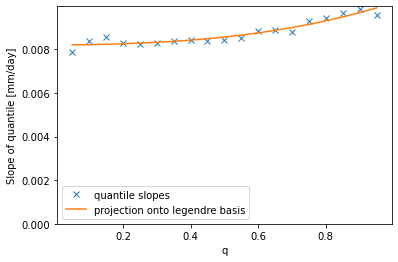

In [11]:
# Coefficients for observed quantile slopes

bootstrap_path = os.path.join(DATA_PATH, 'slopes_pensacola_JJASON')

s = np.empty(19)    # Slope for each quantile
for i, q in enumerate(qs):
    s[i] = np.load(os.path.join(bootstrap_path, 'slope_q_{:.2}.npy'.format(q))).item()
coeffs = linalg.lstsq(A, s)[0]
coeffs

# Plotting BS to see least squares solution
plt.plot(qs, s, ls='', marker='x', label='quantile slopes')
plt.ylim(0, None)
plt.xlabel('q')
plt.ylabel('Slope of quantile [mm/day]')
plt.plot(qs, A @ coeffs, label='projection onto legendre basis')
plt.legend();

print(coeffs)
weights = coeffs**2 / linalg.norm(coeffs)**2
print(np.array2string(weights, precision=3, suppress_small=True))

Compute significances
`sigs` : list of booleans which are T/F depending on whether the coefficients are in the significance ranges

In [12]:
# Compute significances
sigs = [coeffs[i] not in significance_intervals[i] for i in range(4)]
sigs

[True, False, False, False]

Looks like only the coefficient for the mean is significant, so let's plot histograms of the bootstrapped coefficients and see whether the true coefficients reside in the 95% significance range.

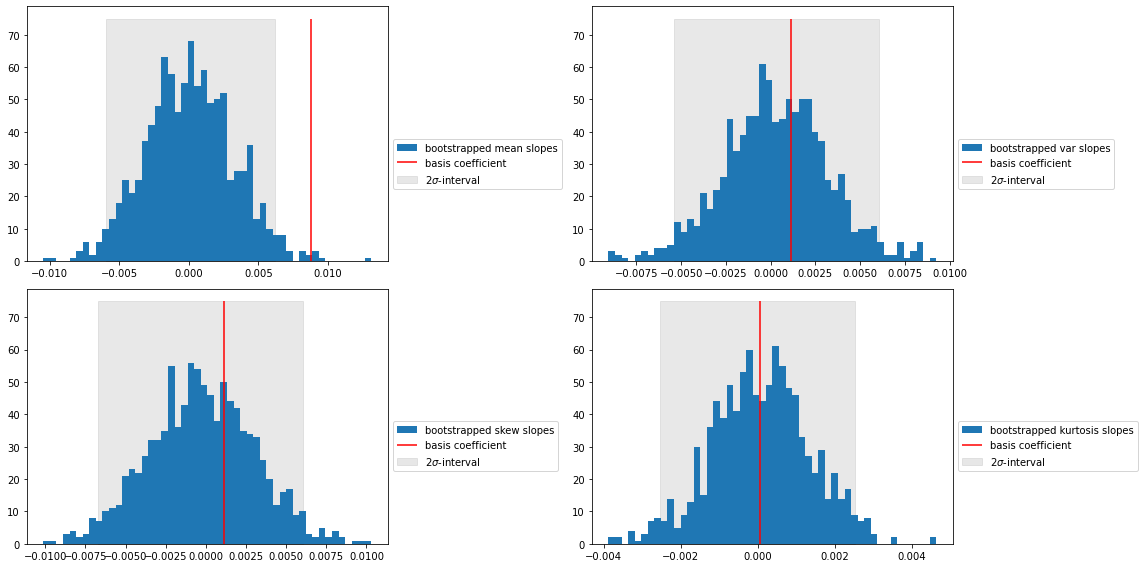

In [13]:
fig, axes = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
axes = axes.ravel()
for i in range(4):
     axes[i].hist(C[:,i], bins=50, label='bootstrapped {} slopes'.format(attrs.moments[i]));
     axes[i].vlines(coeffs[i], 0, 75, color='r', label='basis coefficient')
     axes[i].fill_between([significance_intervals[i].left, significance_intervals[i].right],
          75, alpha=0.3, color=(0.7,0.7,0.7), label=r'$2\sigma$-interval')
     axes[i].legend(bbox_to_anchor=(1,0.5));

fig.tight_layout()

$v \approx c_1 v_1 + c_2 v_2 + c_3 v_3 + c_4 v_4$